<a href="https://colab.research.google.com/github/LDankert/ANNs-Tensorflow/blob/main/Homework_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

## **1. Preprocessing**

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteIQN19G/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteIQN19G/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


,image,label
0,,7 (horse)
1,,8 (ship)
2,,4 (deer)
3,,4 (deer)
4,,6 (frog)
5,,5 (dog)
6,,2 (bird)
7,,9 (truck)
8,,6 (frog)
9,,6 (frog)

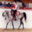
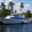
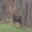
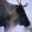
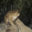
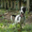
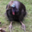
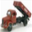
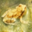
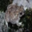

In [2]:
(train_ds, test_ds), info = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

def preprocess_dataset(dataset):
  dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))
  dataset = dataset.map(lambda img, target: ((img/128.)-1., target))
  dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  dataset = dataset.shuffle(buffer_size=1000)
  dataset = dataset.batch(64)
  dataset = dataset.prefetch(2) 
  return dataset

training_ds = train_ds.apply(preprocess_dataset)
testing_ds = test_ds.apply(preprocess_dataset)

tfds.as_dataframe(train_ds.take(10), info)

In [ ]:
training_ds, testing_ds

(<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>)

## **2. Residual Block**




In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class ResidualBlock(Layer):
  def __init__(self, num_filters):
    super(ResidualBlock, self).__init__()
  
    self.filter1, self.filter2 = num_filters

    self.ResBlockLayers = [
                           tf.keras.layers.Conv2D(filters=self.filter1, kernel_size=(3,3), padding="same",  activation=None),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.ReLU(),
                           tf.keras.layers.Conv2D(filters=self.filter2, kernel_size=(3,3), padding="same",  activation=None),
                           tf.keras.layers.BatchNormalization(),
                           ]
     
  @tf.function 
  def call(self, x, training = True):
      output = x

      for layer in self.ResBlockLayers:
        output = layer(output, training = training)
      
      output = x + output

      return tf.nn.relu(output)

## **3. ResNet**

In [4]:
class ResNet(Model):

  def __init__(self):
    super(ResNet, self).__init__()

    self.ResNetLayers = [
                         tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same",  activation=None),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.ReLU()
                         ]  

    self.ResNetLayers.append(ResidualBlock(num_filters=[64,64]))
    self.ResNetLayers.append(ResidualBlock(num_filters=[64,64]))

    self.PoolingBlock1 = [
                          tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2), strides = 2, padding="same",  activation=None),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.ReLU(),
                          tf.keras.layers.Dropout(0.5)
                          ]

    self.ResNetLayers.extend(self.PoolingBlock1)

    self.ResNetLayers.append(ResidualBlock(num_filters=[128,128]))
    self.ResNetLayers.append(ResidualBlock(num_filters=[128,128]))

    self.PoolingBlock2 = [
                          tf.keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides = 2, padding="same",  activation=None),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.ReLU(),
                          tf.keras.layers.Dropout(0.5)
                          ]

    self.ResNetLayers.extend(self.PoolingBlock2)

    self.ResNetLayers.append(ResidualBlock(num_filters=[256,256]))
    self.ResNetLayers.append(ResidualBlock(num_filters=[256,256]))

    self.Classifier = [
                       tf.keras.layers.GlobalAveragePooling2D(),
                       tf.keras.layers.Dense(units=128, activation=None), 
                       tf.keras.layers.BatchNormalization(), 
                       tf.keras.layers.ReLU(),
                       tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
                       ]
   
    self.ResNetLayers.extend(self.Classifier)

  @tf.function    
  def call(self, x, training = True):
    for layer in self.ResNetLayers:
      x = layer(x, training = training)
    return x

## **4. Transition Layers**

In [5]:
class TransitionLayers(Layer):
  
  def __init__(self, num_filters):
    super(TransitionLayers, self).__init__()

    self.filter1, self.filter2 = num_filters

    self.TransitionLayer = [
                            tf.keras.layers.BatchNormalization(epsilon=0.001),
                            tf.keras.layers.ReLU(),                           
                            tf.keras.layers.Conv2D(filters=self.filter1, kernel_size=(1,1), strides=1, padding="same",  activation=None),
                            tf.keras.layers.BatchNormalization(epsilon=0.001),
                            tf.keras.layers.ReLU(),
                            tf.keras.layers.Conv2D(filters=self.filter2, kernel_size=(2,2), strides=2, padding="same",  activation=None),
                            tf.keras.layers.Dropout(0.5)
                            ]

  @tf.function 
  def call(self, x, training=True):
    for layer in self.TransitionLayer:
      x = layer(x, training = training)
    return x

## **5. Block**

In [6]:
class Block(Layer):

  def __init__(self, filter, growth_rate):
    super(Block, self).__init__()

    self.BlockLayers = [
                        tf.keras.layers.BatchNormalization(epsilon=0.001),
                        tf.keras.layers.ReLU(),
                        tf.keras.layers.Conv2D(filters=filter, kernel_size=(1,1), padding="same",  activation=None),
                        tf.keras.layers.BatchNormalization(epsilon=0.001),
                        tf.keras.layers.ReLU(),
                        tf.keras.layers.Conv2D(filters=growth_rate, kernel_size=(3,3), padding="same",  activation=None)
                        ]

    self.concatenate = tf.keras.layers.Concatenate()

  @tf.function 
  def call(self, x, training=True):
    y = x

    for layer in self.BlockLayers:
      y = layer(y, training = training)

    y = self.concatenate([y,x])
    return y

##**6. Dense Block**

In [7]:
class DenseBlock(Layer):

  def __init__(self, filter, growth_rate, num_blocks):
    super(DenseBlock, self).__init__()

    self.DenseBlockLayers = [Block(filter, growth_rate) for _ in range(num_blocks)]


  @tf.function 
  def call(self, x, training=True):
    for block in self.DenseBlockLayers:
      x = block(x, training = training)

    return x

## **7. DenseNet**

In [8]:
class DenseNetwork(Model):

  def __init__(self):
    super(DenseNetwork, self).__init__()

    self.DenseNetLayers = [tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same",  activation=None)]

    self.DenseNetLayers.append(DenseBlock(filter=32, growth_rate=32, num_blocks=4))

    self.DenseNetLayers.append(TransitionLayers(num_filters=[32,64]))

    self.DenseNetLayers.append(DenseBlock(filter=64, growth_rate=64, num_blocks=4))

    self.DenseNetLayers.append(TransitionLayers(num_filters=[64,128]))

    self.DenseNetLayers.append(DenseBlock(filter=128, growth_rate=128, num_blocks=4))


    self.Classifier = [
                       tf.keras.layers.BatchNormalization(epsilon=0.001),
                       tf.keras.layers.ReLU(),
                       tf.keras.layers.GlobalAvgPool2D(), 
                       tf.keras.layers.Dense(units=128, activation=None), 
                       tf.keras.layers.BatchNormalization(epsilon=0.001), 
                       tf.keras.layers.ReLU(),
                       tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
                       ]
   
    self.DenseNetLayers.extend(self.Classifier)

  @tf.function    
  def call(self, x, training = True):
    for layer in self.DenseNetLayers:
      x = layer(x, training = training)
    return x

## **8. Training**

In [9]:
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)                                     
    loss = loss_function(target, prediction)                                                                    
  gradients = tape.gradient(loss, model.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))  
  return loss

def test(model, test_data, loss_function):

  test_accuracy_aggregator = []
  test_loss_aggregator = [] 

  for (input, target) in test_data:
    prediction = model(input, training=False)
    sample_test_loss = loss_function(target, prediction) 
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [10]:
tf.keras.backend.clear_session()

num_epochs = 50
learning_rate = 0.1
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy() 
optimizer = tf.keras.optimizers.Adam(learning_rate) 

model = DenseNetwork()

In [11]:
train_losses = []

test_losses = []
test_accuracies = []

test_loss, test_accuracy = test(model, testing_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, training_ds, cross_entropy_loss)
train_losses.append(train_loss)

In [12]:
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    epoch_loss_agg = []
    for input, target in training_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    test_loss, test_accuracy = test(model, testing_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.10041799363057324
Epoch: 1 starting with accuracy 0.26054936305732485
Epoch: 2 starting with accuracy 0.4380971337579618
Epoch: 3 starting with accuracy 0.43570859872611467
Epoch: 4 starting with accuracy 0.4602906050955414
Epoch: 5 starting with accuracy 0.5193073248407644
Epoch: 6 starting with accuracy 0.5522492038216561
Epoch: 7 starting with accuracy 0.5788216560509554
Epoch: 8 starting with accuracy 0.615843949044586
Epoch: 9 starting with accuracy 0.6978503184713376
Epoch: 10 starting with accuracy 0.6957603503184714
Epoch: 11 starting with accuracy 0.7470143312101911
Epoch: 12 starting with accuracy 0.7754777070063694
Epoch: 13 starting with accuracy 0.7662221337579618
Epoch: 14 starting with accuracy 0.7554737261146497
Epoch: 15 starting with accuracy 0.7589570063694268
Epoch: 16 starting with accuracy 0.7609474522292994
Epoch: 17 starting with accuracy 0.7541799363057324
Epoch: 18 starting with accuracy 0.789609872611465
Epoch: 19 starting wi

## **9. Visualisation**

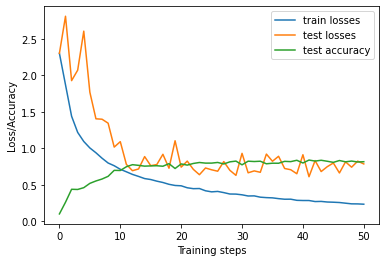

In [13]:
# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("train losses","test losses", "test accuracy"))
plt.show()

In [14]:
model.summary()

Model: "dense_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 dense_block (DenseBlock)    multiple                  49152     
                                                                 
 transition_layers (Transiti  multiple                 14176     
 onLayers)                                                       
                                                                 
 dense_block_1 (DenseBlock)  multiple                  192512    
                                                                 
 transition_layers_1 (Transi  multiple                 54976     
 tionLayers)                                                     
                                                                 
 dense_block_2 (DenseBlock)  multiple                